In [16]:
import numpy as np
import h5py as h5
import csv
import pandas as pd
from scipy.io import loadmat
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.offline as py
import sklearn
import pickle
import scipy
import nltk
import matplotlib.pyplot as plt
import json
import ast
from datetime import datetime
import datetime as dt
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.stats import spearmanr, pearsonr
import pdb
from string import digits
from sklearn import preprocessing
from sklearn.utils import shuffle
from wordcloud import WordCloud
import copy
import re
import nltk
from scipy import stats
from dython.nominal import conditional_entropy, cramers_v, theils_u, correlation_ratio
from mpl_toolkits import mplot3d
from kneed import KneeLocator
import scikit_posthocs

In [4]:
tsv_read = pd.read_csv('mfp-diary-dataset/mfp-diaries-new.tsv', sep='\t', header=None)
taxonomy_list = pd.read_csv('mfp-diary-dataset/food_taxonomy.txt', sep='\t',  header=None)

In [7]:
def remove_unicode(x):
    
    string_unicode = x
    string_encode = string_unicode.encode("ascii", "backslashreplace")
    string_decode = string_encode.decode()
    
    return string_decode





non_food = ['quick added calories',
            'quick add - quick add - 100 calories',
            'quick added kilojoules',
            'quick added calories - one calorie',
            '', ]

all_food_dict = []

mfp_pcts = []
mfp_df = []

pcts = np.sort(np.unique(tsv_read[0]))
err_pcts = []

for idn in pcts:
    

    
        meal_info = pd.DataFrame()
        idx_pct = np.where(tsv_read[0]==idn)[0]
        unique_dates = np.unique(tsv_read[1][idx_pct])
        dates = [datetime.strptime(c, "%Y-%m-%d") for c in unique_dates]



        if (len(unique_dates) > 13 ):

            dates_all = np.array(tsv_read[1][idx_pct])
            food_all = np.array(tsv_read[2][idx_pct])
            goal_cal = np.array(tsv_read[3][idx_pct])



            for i in range(0, len(unique_dates)):

                #print(i)

    #             try:

                meal_series = pd.Series({'Date': unique_dates[i]})
                idx_date = np.where(dates_all==unique_dates[i])[0]



                meals_n = len(ast.literal_eval(food_all[idx_date][0]))

                tag = False


                if meals_n == 4:

                    meal_name_ext = []

                    for j in range(0, meals_n):


                        meal_name = ast.literal_eval(food_all[idx_date][0])[j]['meal'].lower()
                        meal_name = remove_unicode(meal_name)
                        meal_name_ext.append(meal_name)





                    if (''.join(np.sort(meal_name_ext)) == ''.join(np.sort(['breakfast', 'snacks', 'dinner', 'lunch'])) ) :

                        for j in range(0, meals_n):

                            meal_name = ast.literal_eval(food_all[idx_date][0])[j]['meal'].lower()

                            dish_n = len(ast.literal_eval(food_all[idx_date][0])[j]['dishes'])
                            meal_cal = []
                            meal_carb = []
                            meal_fat = []
                            meal_sugar = []
                            meal_protein =[]
                            
                            
                            ty_names = []
                          
                            for ty in range(len(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][0]['nutritions'])):
                                ty_names.append(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][0]['nutritions'][ty]['name'])
                                if (ast.literal_eval(food_all[idx_date][0])[j]['dishes'][0]['nutritions'][ty]['name'] == 'Calories'):

                                    i_cal = ty
                                    

                                elif (ast.literal_eval(food_all[idx_date][0])[j]['dishes'][0]['nutritions'][ty]['name'] == 'Carbs'):
                                    i_car = ty
                                    

                                elif (ast.literal_eval(food_all[idx_date][0])[j]['dishes'][0]['nutritions'][ty]['name'] == 'Fat'):
                                    i_fat = ty
                                    

                                elif (ast.literal_eval(food_all[idx_date][0])[j]['dishes'][0]['nutritions'][ty]['name'] == 'Protein'):
                                    i_pro = ty
                                   

                                else:
                                    tag = False
                                
                            if 'Calories' in ty_names and 'Carbs' in ty_names and 'Fat' in ty_names and 'Protein' in ty_names:
                                
                                tag = False
                                
                            else:
                                
                                tag = True
                                break
                                
                    
                            for k in range(0, dish_n):
                                
                                


                                dish_cal = ast.literal_eval(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][k]['nutritions'][i_cal]['value'].replace(',',''))

                                dish_carb = ast.literal_eval(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][k]['nutritions'][i_car]['value'].replace(',',''))

                                dish_fat = ast.literal_eval(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][k]['nutritions'][i_fat]['value'].replace(',',''))

                                dish_protein = ast.literal_eval(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][k]['nutritions'][i_pro]['value'].replace(',',''))


                                
                                if i_cal !=0:
                                    print("not correct: {0}".format(idn))
                
                                if isinstance(dish_cal, tuple):
                        
                                    print(dish_cal)
                                    print(ast.literal_eval(food_all[idx_date][0])[j]['dishes'][k]['nutritions'][i_cal]['value'].replace(',',''))

                                    dish_cal = dish_cal[0]*1000 + dish_cal[1]
                                    

                                if dish_cal < 3000 and dish_cal >= 0:

                                    

                                    meal_cal.append(dish_cal)
                                    meal_carb.append(dish_carb)
                                    meal_fat.append(dish_fat)
                                    meal_protein.append(dish_protein)

                    

                                else:

                                    meal_cal = []


                                    tag = True

                                    break


                            if (len(meal_cal) != 0 and tag == False):
                                meal_series = meal_series.append(pd.Series({meal_name+'-cal': meal_cal, meal_name+'-carb': meal_carb, 
                                                                            meal_name+'-fat': meal_fat, meal_name+'-protein': meal_protein}))
                                





                        if tag == False:
                            meal_series = meal_series.append(pd.Series({"Goal": ast.literal_eval(goal_cal[idx_date][0])["goal"][0]['value'], 'Total-cal':ast.literal_eval(goal_cal[idx_date][0])["total"][i_cal]['value'], 
                                                                        'Total-carb':ast.literal_eval(goal_cal[idx_date][0])["total"][i_car]['value'], 'Total-fat':ast.literal_eval(goal_cal[idx_date][0])["total"][i_fat]['value'],
                                                                       'Total-protein':ast.literal_eval(goal_cal[idx_date][0])["total"][i_pro]['value']}))
                            meal_info = meal_info.append(meal_series, ignore_index=True)




            meal_info_dropped = meal_info.dropna()  
            if (len(meal_info_dropped) != 0 ):
                mfp_pcts.append(idn)
                mfp_df.append(meal_info_dropped)
                print(idn)





2
4
12
15
16
20
21
23
24
26
29
30
32
33
34
36
37
38
40
43
44
49
50
51
52
57
62
65
67
68
71
73
74
75
76
79
82
84
85
86
89
90
92
95
100
101
102
103
104
106
108
110
112
113
114
115
116
120
122
125
126
127
129
130
133
135
137
138
141
143
151
159
160
165
167
175
178
186
190
192
197
199
200
201
205
206
209
211
212
215
223
226
227
228
232
234
236
237
238
240
241
243
244
245
249
251
255
256
258
262
264
265
268
270
272
275
276
278
279
280
281
282
283
286
287
292
295
299
303
305
306
309
310
312
313
317
318
319
320
322
331
333
335
344
346
348
350
352
353
354
355
357
359
363
366
368
369
371
383
386
390
391
392
394
396
398
404
405
406
408
410
417
419
424
426
427
428
429
433
436
438
444
448
449
451
454
457
460
461
466
470
474
475
477
481
483
487
488
492
493
494
495
496
501
502
504
505
506
509
510
511
512
517
518
520
523
524
525
528
530
532
533
534
536
537
538
540
543
545
547
550
553
554
555
564
566
567
574
577
581
582
584
592
595
597
599
606
608
609
614
615
617
618
620
626
630
633
634
637
640
642
64

4315
4318
4319
4323
4327
4330
4331
4333
4335
4337
4341
4342
4351
4352
4354
4357
4361
4362
4363
4366
4367
4368
4370
4373
4376
4378
4379
4381
4384
4385
4386
4389
4390
4392
4393
4395
4396
4397
4399
4400
4401
4402
4403
4405
4407
4408
4413
4415
4417
4418
4419
4420
4421
4424
4425
4427
4429
4430
4435
4436
4438
4440
4441
4443
4447
4449
4451
4452
4453
4455
4456
4457
4459
4462
4468
4469
4470
4472
4475
4477
4478
4480
4481
4485
4489
4491
4493
4494
4495
4496
4499
4505
4506
4512
4513
4515
4521
4525
4526
4530
4534
4535
4539
4540
4541
4542
4546
4547
4553
4555
4556
4562
4563
4565
4567
4568
4569
4571
4572
4574
4576
4581
4582
4584
4592
4593
4596
4598
4599
4607
4609
4611
4617
4620
4623
4627
4630
4631
4636
4637
4639
4640
4643
4644
4645
4648
4651
4652
4654
4655
4658
4663
4665
4666
4667
4671
4673
4676
4678
4680
4681
4685
4689
4691
4692
4694
4695
4699
4705
4707
4708
4711
4720
4721
4725
4733
4735
4736
4738
4743
4750
4753
4754
4755
4756
4757
4758
4759
4760
4762
4763
4765
4766
4767
4769
4775
4776
4778
4780
4783


8451
8454
8455
8459
8460
8462
8463
8464
8466
8468
8469
8474
8480
8483
8486
8488
8489
8491
8492
8495
8504
8505
8507
8511
8515
8516
8517
8521
8522
8526
8528
8532
8534
8544
8547
8549
8550
8553
8554
8557
8558
8559
8562
8564
8568
8570
8572
8573
8574
8575
8576
8577
8578
8586
8592
8599
8600
8602
8603
8605
8606
8607
8613
8615
8618
8619
8620
8625
8627
8628
8629
8637
8639
8640
8641
8642
8644
8645
8646
8648
8653
8655
8656
8657
8665
8666
8671
8672
8675
8676
8678
8679
8681
8682
8683
8687
8691
8694
8697
8699
8705
8706
8708
8712
8714
8718
8720
8724
8725
8726
8728
8731
8734
8735
8736
8737
8739
8743
8744
8749
8750
8752
8753
8757
8759
8760
8761
8764
8765
8766
8769
8772
8773
8775
8779
8781
8786
8787
8788
8791
8792
8799
8801
8802
8803
8813
8815
8820
8821
8825
8828
8832
8833
8843
8845
8848
8849
8850
8851
8852
8854
8855
8857
8860
8862
8864
8868
8869
8873
8876
8879
8880
8882
8883
8887
8889
8892
8903
8908
8911
8912
8913
8916
8919
8921
8922
8928
8930
8935
8937
8938
8939
8940
8942
8947
8948
8952
8958
8960
8961


In [9]:
pickle.dump(mfp_pcts, open( "mfp-diary-dataset/Calorie_comp_2022.pkl", "wb" ))
pickle.dump(mfp_df, open( "mfp-diary-dataset/dataCalorie_comp_2022.pkl", "wb" ))

In [10]:
mfp_pcts = pickle.load(open( "mfp-diary-dataset/Calorie_comp_2022.pkl", "rb" ) )
mfp_df = pickle.load(open( "mfp-diary-dataset/dataCalorie_comp_2022.pkl", "rb" ) )
user_prof = pd.read_csv('mfp-diary-dataset/profiles.csv', sep=',')

In [12]:
import warnings
warnings.filterwarnings("ignore")
    
# calculate the kl divergence

def crosscomp(dates, preload, test, total_cal, lb):
    


    preload_c = np.empty((((dates[-1]-dates[0]).days + 1)))
    test_c = np.empty((((dates[-1]-dates[0]).days + 1)))
    total_c = np.empty((((dates[-1]-dates[0]).days + 1)))

    preload_c[:] = np.nan
    test_c[:] = np.nan
    total_c[:] = np.nan



    for i,d in enumerate(dates):


        preload_c[(d-dates[0]).days] = preload[i]
        test_c[(d-dates[0]).days] = test[i]
        total_c[(d-dates[0]).days] = total_cal[i]
            
        
    pre = []
    tag = []
    tcal = []
    d_ind = []
    
    pre_all = []
    
    tes = []
 
    

    
    for i in range(1, len(preload_c)):
        
        if ~np.isnan(preload_c[i]) and ~np.isnan(np.nanmedian(preload_c[np.max([i-7, 0]): i])):
            
            pre_temp = preload_c[i] - np.nanmedian(preload_c[np.max([i-7, 0]): i])
            tes_temp = test_c[i] - np.nanmedian(test_c[np.max([i-7, 0]): i])
            tcal_temp = total_c[i]
            
            pre_all.append(pre_temp)
            ratio_temp = tes_temp/ pre_temp
            diff_temp =  np.abs(tes_temp) -  np.abs(pre_temp)
            diff_add = np.abs(tes_temp) +  np.abs(pre_temp)
            
#             if np.isnan(ratio_temp):
                
#                 print('______')
#                 print(i)
                
#                 print(preload_c[i])
#                 print(test_c[i])
                
#                 print(np.nanmean(preload_c[i-7: i]))
#                 print(np.nanmean(test_c[i-7: i]))
                
#                 print(preload_c)
            
        
            
            if np.abs(pre_temp) > 0 :
            
                if ratio_temp>=0:

                    tag.append(2)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)
                    d_ind.append(i)
                    tes.append(tes_temp)

                elif ratio_temp <-1.2:
                    tag.append(-2)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)
                    d_ind.append(i)
                    tes.append(tes_temp)


                elif ratio_temp > -0.8 and ratio_temp < 0:
                    tag.append(1)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)
                    d_ind.append(i)
                    tes.append(tes_temp)

                elif ratio_temp<=-0.8 and ratio_temp>= -1.2:

                    tag.append(-1)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)
                    d_ind.append(i)
                    tes.append(tes_temp)


                else:

                    continue

            else:
                
                continue
                
    
            
                
     
    pre = np.array(pre)
    tag = np.array(tag)
    tcal = np.array(tcal)
  
    
    
    
    
    if len(pre) > 0 :
       
        

        
    
        label = np.arange(len(pre))
        comp_l = tag[label]

        pro_m = [len(np.where(comp_l == 1)[0])/len(comp_l),
                             len(np.where(comp_l == -1)[0])/len(comp_l),
                             len(np.where(comp_l == -2)[0])/len(comp_l),
                             len(np.where(comp_l == 2)[0])/len(comp_l)]

        label = np.where(pre > 0)[0]
        comp_l = tag[label]
        t_cal = tcal[label]

        if len(label) > 0:

            pro_pos = [len(np.where(comp_l == 1)[0])/len(comp_l),
                                 len(np.where(comp_l == -1)[0])/len(comp_l),
                                 len(np.where(comp_l == -2)[0])/len(comp_l),
                                 len(np.where(comp_l == 2)[0])/len(comp_l)]


            tcal_pos = [(np.mean(t_cal[ ( comp_l == 1)]) ),
                                     np.median(t_cal[( comp_l == -1)]),
                                     np.median(t_cal[ ( comp_l == -2)]),
                                     np.median(t_cal[ ( comp_l == 2)])]
        else:
            
            pro_pos = [np.nan, np.nan, np.nan, np.nan]
            tcal_pos = [np.nan, np.nan, np.nan, np.nan]
        
            

        label = np.where(pre < 0)[0]
        comp_l = tag[label]
        t_cal = tcal[label]
        
        if len(label) > 0:

            pro_neg = [len(np.where(comp_l == 1)[0])/len(comp_l),
                                 len(np.where(comp_l == -1)[0])/len(comp_l),
                                 len(np.where(comp_l == -2)[0])/len(comp_l),
                                 len(np.where(comp_l == 2)[0])/len(comp_l)]

            tcal_neg = [(np.median(t_cal[( comp_l == 1)]) ),
                             np.median(t_cal[ ( comp_l == -1)]),
                             np.median(t_cal[( comp_l == -2)]),
                             np.median(t_cal[( comp_l == 2)])]
            
        else:
            
            pro_neg = [np.nan, np.nan, np.nan, np.nan]
            tcal_neg = [np.nan, np.nan, np.nan, np.nan]
        
        
        
    else:
        
        pro_m = [np.nan, np.nan, np.nan, np.nan]
        pro_pos = [np.nan, np.nan, np.nan, np.nan]
        pro_neg = [np.nan, np.nan, np.nan, np.nan]
        tcal_pos = [np.nan, np.nan, np.nan, np.nan]
        tcal_neg = [np.nan, np.nan, np.nan, np.nan]

    
    pre_all = np.array(pre_all)
    
    
    
    
    return pro_m, pro_pos, pro_neg, tcal_pos, tcal_neg, np.std(pre_all)/np.mean(pre_all)


def crossday(dates, preload, test, total_cal, lb):
    
    preload_i = np.empty((((dates[-1]-dates[0]).days + 1)))
    preload_c = np.empty((((dates[-1]-dates[0]).days)))
    test_c = np.empty((((dates[-1]-dates[0]).days)))
    total_c = np.empty((((dates[-1]-dates[0]).days)))
    total_i = np.empty((((dates[-1]-dates[0]).days + 1)))

    preload_c[:] = np.nan
    test_c[:] = np.nan
    total_c[:] = np.nan
    total_i[:] =  np.nan
    preload_i[:] =  np.nan

    for i,d in enumerate(dates):

        preload_i[(d-dates[0]).days] = preload[i]
        total_i[(d-dates[0]).days] = total_cal[i]

    preload_c = preload_i[0:-1]
    test_c = preload_i[1:]
    total_c = total_i[1:]
    
    
    
        
        
    pre = []
    tag = []
    tcal = []
    
    pre_all = []
    
    for i in range(1, len(preload_c)):
        
        if ~np.isnan(preload_c[i]) and ~np.isnan(np.nanmedian(preload_c[np.max([i-7, 0]): i])) and ~np.isnan(test_c[i]):
            
            pre_temp = preload_c[i] - np.nanmedian(preload_c[np.max([i-7, 0]): i])
            tes_temp = test_c[i] - np.nanmedian(test_c[np.max([i-7, 0]): i])
            tcal_temp = total_c[i]
            
            pre_all.append(pre_temp)
            
            
            
            
            ratio_temp = tes_temp/ pre_temp
            diff_temp =  np.abs(tes_temp) -  np.abs(pre_temp)
            
#             if np.isnan(ratio_temp):
                

                
#                 print(preload_c[i])
#                 print(test_c[i])
                
#                 print(np.nanmean(preload_c[i-7: i]))
#                 print(np.nanmean(test_c[i-7: i]))
                
#                 print(preload_c)
            
            if np.abs(pre_temp) > 0:
            
                if ratio_temp>=0:

                    tag.append(2)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)

                elif ratio_temp <-1.2:
                    tag.append(-2)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)


                elif ratio_temp > -0.8 and ratio_temp < 0:
                    tag.append(1)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)

                elif ratio_temp <=-0.8 and ratio_temp >= -1.2:

                    tag.append(-1)
                    pre.append(pre_temp)
                    tcal.append(tcal_temp)


                else:

                    continue

            else:
                
                continue
            
                
     
    pre = np.array(pre)
    tag = np.array(tag)
    tcal = np.array(tcal)
    
    
    
    if len(pre) > 0:
        
        
    
    
        label = np.arange(len(pre))
        comp_l = tag[label]

        pro_m = [len(np.where(comp_l == 1)[0])/len(comp_l),
                             len(np.where(comp_l == -1)[0])/len(comp_l),
                             len(np.where(comp_l == -2)[0])/len(comp_l),
                             len(np.where(comp_l == 2)[0])/len(comp_l)]

        label = np.where(pre > 0)[0]
        comp_l = tag[label]
        t_cal = tcal[label]
        
        if len(label) > 0:

            pro_pos = [len(np.where(comp_l == 1)[0])/len(comp_l),
                                 len(np.where(comp_l == -1)[0])/len(comp_l),
                                 len(np.where(comp_l == -2)[0])/len(comp_l),
                                 len(np.where(comp_l == 2)[0])/len(comp_l)]


            tcal_pos = [(np.median(t_cal[ ( comp_l == 1)]) ),
                                     np.median(t_cal[( comp_l == -1)]),
                                     np.median(t_cal[ ( comp_l == -2)]),
                                     np.median(t_cal[ ( comp_l == 2)])]
        else:
            
            pro_pos = [np.nan, np.nan, np.nan, np.nan]
            tcal_pos = [np.nan, np.nan, np.nan, np.nan]
        
            

        label = np.where(pre < 0)[0]
        comp_l = tag[label]
        t_cal = tcal[label]
        
        if len(label) > 0:

            pro_neg = [len(np.where(comp_l == 1)[0])/len(comp_l),
                                 len(np.where(comp_l == -1)[0])/len(comp_l),
                                 len(np.where(comp_l == -2)[0])/len(comp_l),
                                 len(np.where(comp_l == 2)[0])/len(comp_l)]

            tcal_neg = [(np.median(t_cal[( comp_l == 1)]) ),
                             np.median(t_cal[ ( comp_l == -1)]),
                             np.median(t_cal[( comp_l == -2)]),
                             np.median(t_cal[( comp_l == 2)])]
            
        else:
            
            pro_neg = [np.nan, np.nan, np.nan, np.nan]
            tcal_neg = [np.nan, np.nan, np.nan, np.nan]
        
        
    else:
        
        pro_m = [np.nan, np.nan, np.nan, np.nan]
        pro_pos = [np.nan, np.nan, np.nan, np.nan]
        pro_neg = [np.nan, np.nan, np.nan, np.nan]
        tcal_pos = [np.nan, np.nan, np.nan, np.nan]
        tcal_neg = [np.nan, np.nan, np.nan, np.nan]

    
    pre_all = np.array(pre_all)
    
    
    
    
    return pro_m, pro_pos, pro_neg, tcal_pos, tcal_neg, np.std(pre_all)/np.mean(pre_all)
 

In [14]:
df_final_table =  pd.DataFrame(columns=[])

for i in range(0, len(mfp_df)):

#             print(i)

    cal_pcts_dates = mfp_df[i]['Date'].values


    cal_pcts_dates = np.array(cal_pcts_dates)
    dates = [datetime.strptime(c, "%Y-%m-%d") for c in  cal_pcts_dates]

    record_days=len(dates)

    if record_days > 1:
        lapsing_dur = np.mean(np.diff(dates)).days-1

#         n_conse_1 = len(np.where(np.array([x.days for x in np.diff(dates)]) == 1)[0])

    if record_days >=28 and lapsing_dur<=3 and 'breakfast-cal' in mfp_df[i].keys() and 'lunch-cal' in mfp_df[i].keys() and 'dinner-cal' in mfp_df[i].keys() and 'snacks-cal' in mfp_df[i].keys() and len(mfp_df[i].keys())==22:

        print(mfp_pcts[i])

        complete_dates = cal_pcts_dates
        meal_cal = mfp_df[i].copy()

        b_cal = np.array([np.sum(vv) for vv in meal_cal['breakfast-cal'].values])
        l_cal = np.array([np.sum(vv) for vv in meal_cal['lunch-cal'].values])
        d_cal = np.array([np.sum(vv) for vv in meal_cal['dinner-cal'].values])
        s_cal = np.array([np.sum(vv) for vv in meal_cal['snacks-cal'].values])


        b_carb = np.array([np.sum(vv) for vv in meal_cal['breakfast-carb'].values])
        l_carb = np.array([np.sum(vv) for vv in meal_cal['lunch-carb'].values])
        d_carb = np.array([np.sum(vv) for vv in meal_cal['dinner-carb'].values])
        s_carb = np.array([np.sum(vv) for vv in meal_cal['snacks-carb'].values])


        b_pro = np.array([np.sum(vv) for vv in meal_cal['breakfast-protein'].values])
        l_pro = np.array([np.sum(vv) for vv in meal_cal['lunch-protein'].values])
        d_pro = np.array([np.sum(vv) for vv in meal_cal['dinner-protein'].values])
        s_pro = np.array([np.sum(vv) for vv in meal_cal['snacks-protein'].values])


        b_fat = np.array([np.sum(vv) for vv in meal_cal['breakfast-fat'].values])
        l_fat = np.array([np.sum(vv) for vv in meal_cal['lunch-fat'].values])
        d_fat = np.array([np.sum(vv) for vv in meal_cal['dinner-fat'].values])
        s_fat = np.array([np.sum(vv) for vv in meal_cal['snacks-fat'].values])



        t_cal = meal_cal["Total-cal"].values
        t_carb = meal_cal["Total-carb"].values
        t_pro = meal_cal["Total-protein"].values
        t_fat = meal_cal["Total-fat"].values


        g_cal = meal_cal["Goal"].values
        
#         if (np.mean(t_cal)<= 750):
#             print(mfp_pcts[i])
#             print(meal_cal)
#             break



        a_cal = (g_cal-t_cal)/g_cal
        aa_cal = (g_cal-t_cal)

        above_goal = len(np.where(a_cal < -0.10)[0])/len(a_cal)
        below_goal = len(np.where(a_cal >= 0)[0])/len(a_cal)


        adh_lab = below_goal

        df = meal_cal
        df['Date'] = pd.to_datetime(df['Date'])
        df["Day"] = df['Date'].dt.day_name()

        m_cal = l_cal + s_cal

        all_cal = l_cal + s_cal + b_cal

#         print('Breakfast-Lunch')


        rt_bl, rt_pos_bl, rt_neg_bl, tc_pos_bl, tc_neg_bl, cv_bl = crosscomp(dates, b_cal, m_cal, aa_cal, 'meal')



#         print('All-Dinner')
        rt_alld, rt_pos_alld, rt_neg_alld, tc_pos_alld, tc_neg_alld, cv_alld = crosscomp(dates, all_cal, d_cal, aa_cal, 'meal')


        rt_day, rt_pos_day, rt_neg_day, tc_pos_day, tc_neg_day, cv_day = crossday(dates, t_cal,t_cal, aa_cal, 'day')

#         tc_pos_bl.append(np.median(t_cal))
#         tc_pos_alld.append(np.median(t_cal))
#         tc_pos_day.append(np.median(t_cal))
        
#         tc_neg_bl.append(np.median(t_cal))
#         tc_neg_alld.append(np.median(t_cal))
#         tc_neg_day.append(np.median(t_cal))
        
        tc_pos_bl.append(np.min(g_cal))
        tc_pos_alld.append(np.min(g_cal))
        tc_pos_day.append(np.min(g_cal))
        
        tc_neg_bl.append(np.min(g_cal))
        tc_neg_alld.append(np.min(g_cal))
        tc_neg_day.append(np.min(g_cal))



        #######################
        if len(user_prof[user_prof['uid']==mfp_pcts[i]]) !=0 :

            if pd.isna(user_prof[user_prof['uid']==mfp_pcts[i]]['gender'].values[0]): 

                gender = np.nan
            else:                      
                gender =  user_prof[user_prof['uid']==mfp_pcts[i]]['gender'].values[0]

            if pd.isna(user_prof[user_prof['uid']==mfp_pcts[i]]['age_group'].values[0]): 

                age = np.nan
            else:                      
                age =  user_prof[user_prof['uid']==mfp_pcts[i]]['age_group'].values[0]

            if pd.isna(user_prof[user_prof['uid']==mfp_pcts[i]]['regions_us'].values[0]): 

                loc = np.nan
            else:                      
                loc =  user_prof[user_prof['uid']==mfp_pcts[i]]['regions_us'].values[0]

        else:
            gender = np.nan
            age = np.nan
            loc = np.nan




        dic_all = {'uid':mfp_pcts[i], 
                                    'gender': gender,
                                    'age':age,
                                    'loc':loc, 
                                    'rt_day': rt_day,
                                    'rt_alld': rt_alld,
                                    'rt_bl': rt_bl,
                                    'rt_pos_bl': rt_pos_bl,
                                    'rt_neg_bl': rt_neg_bl,
                                    'rt_pos_alld': rt_pos_alld,
                                    'rt_neg_alld': rt_neg_alld,
                                    'rt_pos_day': rt_pos_day,
                                    'rt_neg_day': rt_neg_day,
                  'tc_pos_bl': tc_pos_bl,
                  'tc_neg_bl': tc_neg_bl,
                  'tc_pos_alld': tc_pos_alld,
                  'tc_neg_alld': tc_neg_alld,
                  'tc_pos_day': tc_pos_day,
                  'tc_neg_day': tc_neg_day, 
                  'cv_bl': cv_bl,
                  'cv_alld': cv_alld,
                  'cv_day': cv_day}


        df_series = pd.Series(dic_all)

        df_final_table = df_final_table.append(df_series, ignore_index=True)

        

pickle.dump(df_final_table, open("Caloriefinal_2022.pkl", "wb") )
        
        
        
        
        

2
12
16
32
36
43
44
50
52
62
67
68
82
85
86
95
101
104
108
115
122
135
137
151
159
190
192
200
205
209
211
212
215
226
236
237
241
243
249
256
258
264
268
270
275
279
286
303
306
312
313
318
319
331
333
335
346
350
353
357
366
369
371
386
390
398
408
419
424
429
433
448
451
466
474
475
481
493
494
495
501
502
510
512
518
523
528
530
532
534
538
543
545
550
574
595
606
614
617
633
637
640
642
645
646
649
652
658
659
664
672
675
676
678
690
692
695
698
700
720
724
729
730
736
756
780
783
790
791
794
800
802
809
814
835
838
854
858
861
866
870
871
877
879
880
881
885
887
891
893
897
918
921
934
936
950
958
959
961
971
973
974
978
988
990
992
996
1000
1001
1010
1014
1016
1021
1037
1043
1055
1068
1085
1090
1092
1093
1098
1103
1116
1118
1128
1134
1153
1158
1167
1174
1197
1199
1203
1225
1242
1244
1248
1251
1254
1259
1265
1266
1267
1271
1273
1277
1279
1283
1304
1307
1314
1315
1323
1341
1342
1366
1377
1380
1389
1394
1395
1396
1401
1410
1415
1419
1427
1442
1443
1447
1452
1456
1459
1463
1473
1476

In [41]:
df_final =  pickle.load(open("Caloriefinal_2022.pkl", "rb" ))
temp = pd.DataFrame(np.concatenate((np.stack([x for x in df_final['rt_bl']], axis=0), np.stack([x for x in df_final['rt_alld']], axis=0),
                                   np.stack([x for x in df_final['rt_day']], axis=0)), axis=1))
temp  = temp.dropna()

lbl = []
nbl = []

for i in range(len(temp)):
    lbl.extend(['Under', 'Exact', 'Over', 'Anti'])
    nbl.extend([temp[0].iloc[i], temp[1].iloc[i], temp[2].iloc[i], temp[3].iloc[i]])
lalld = []
nalld = []

for i in range(len(temp)):
    lalld.extend(['Under', 'Exact', 'Over', 'Anti'])
    nalld.extend([temp[4].iloc[i], temp[5].iloc[i], temp[6].iloc[i], temp[7].iloc[i]])
        
lday = []
nday = []

for i in range(len(temp)):
    lday.extend(['Under', 'Exact', 'Over', 'Anti'])
    nday.extend([temp[8].iloc[i], temp[9].iloc[i], temp[10].iloc[i], temp[11].iloc[i]])
    


fig = go.Figure(layout = go.Layout(
        plot_bgcolor="#FFF",  # Sets background color to white
        xaxis=dict(
            linecolor="black",  # Sets color of X-axis line
            showgrid=False  # Removes X-axis grid lines
        ),
        yaxis=dict(
            title='Probability Mass Function',  
            linecolor="black",  # Sets color of Y-axis line
            showgrid=False,  # Removes Y-axis grid lines    
        ),
        font=dict(
            family="Helvetica, monospace",
            size=14,
            color="black"
        )
    ))

fig.add_trace(go.Box(y=nbl, boxpoints=None, boxmean=True, x=lbl, name = 'Lunch'+' $P_{c_l}$', line=dict(color ='blue')))
fig.add_trace(go.Box(y=nalld, boxpoints=None, boxmean=True, x=lalld,  name = 'Dinner $P_{c_d}$',line=dict(color ='green')))
fig.add_trace(go.Box(y=nday, boxpoints=None, boxmean=True, x=lday,  name = 'Day $P_{c_y}$',line=dict(color ='orange')))
fig.update_layout(
    boxmode='group'
)
fig.update(layout_yaxis_range = [0,1.1])
fig.show()






temp_all = temp.copy()
fig.write_image("comp_paper_images/pc_all_june22"+".svg", engine="kaleido")

print(len(temp_all))
print(scipy.stats.friedmanchisquare(temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7], temp[8]
                                   , temp[9], temp[10], temp[11]))
print(scikit_posthocs.posthoc_wilcoxon([temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7], temp[8]
                                   , temp[9], temp[10], temp[11]], p_adjust='bonferroni'))

# print(len(np.where(temp[1] > 0)[0])/len(temp))
# print(len(np.where(temp[5] > 0)[0])/len(temp))
# print(len(np.where(temp[9] > 0)[0])/len(temp))


print(np.mean(temp[1]))
print(np.mean(temp[5]))
print(np.mean(temp[9]))

print(np.std(temp[1]))
print(np.std(temp[5]))
print(np.std(temp[9]))



print(len(np.where(temp[3] < 0.5)[0])/len(temp))
print(len(np.where(temp[7] <0.5)[0])/len(temp))
print(len(np.where(temp[11]<0.5)[0])/len(temp))

1622
FriedmanchisquareResult(statistic=14498.578723266228, pvalue=0.0)
               1              2              3              4              5   \
1    1.000000e+00  5.739488e-196  7.441252e-254  2.445282e-261  1.151514e-248   
2   5.739488e-196   1.000000e+00  1.749248e-263  1.984237e-264  4.667516e-264   
3   7.441252e-254  1.749248e-263   1.000000e+00   4.998969e-84  9.000427e-102   
4   2.445282e-261  1.984237e-264   4.998969e-84   1.000000e+00  1.372297e-236   
5   1.151514e-248  4.667516e-264  9.000427e-102  1.372297e-236   1.000000e+00   
6    1.574565e-47  2.321241e-110  3.032062e-263  1.194699e-264  1.658160e-256   
7   1.507127e-196  2.484608e-263  5.591285e-223  5.338867e-256   1.136976e-80   
8   9.581171e-262  1.322225e-264   4.439332e-02   1.144028e-97   2.856345e-94   
9   1.241345e-156  1.403577e-259  2.892407e-233  4.348566e-260  1.616049e-160   
10  8.027759e-175   1.000000e+00  1.609052e-264  8.720960e-265  4.943642e-264   
11  1.201478e-172  1.069182e-257  7.40

In [21]:

df_final =  pickle.load(open("Caloriefinal_2022.pkl", "rb" ))
temp = pd.DataFrame(np.concatenate((np.stack([x for x in df_final['rt_pos_bl']], axis=0), np.stack([x for x in df_final['rt_neg_bl']], axis=0)), axis=1))
temp  = temp.dropna()

lbl = []
nbl = []

for i in range(len(temp)):
    lbl.extend(['Under', 'Exact', 'Over', 'Anti'])
#     denom = temp[0].iloc[i]+ temp[1].iloc[i]+ temp[2].iloc[i]
    denom = 1
    nbl.extend([temp[0].iloc[i]/denom, temp[1].iloc[i]/denom, temp[2].iloc[i]/denom, temp[3].iloc[i]])
lalld = []
nalld = []

for i in range(len(temp)):
    lalld.extend(['Under', 'Exact', 'Over', 'Anti'])
#     denom = temp[4].iloc[i]+ temp[5].iloc[i]+ temp[6].iloc[i]
    denom = 1
    nalld.extend([temp[4].iloc[i]/denom, temp[5].iloc[i]/denom, temp[6].iloc[i]/denom, temp[7].iloc[i]])
        
# lday = []
# nday = []

# for i in range(len(temp)):
#     lday.extend(['Under', 'Exact', 'Over', 'Anti'])
#     nday.extend([temp[8].iloc[i], temp[9].iloc[i], temp[10].iloc[i], temp[11].iloc[i]])
    


fig = go.Figure(layout = go.Layout(
        plot_bgcolor="#FFF",  # Sets background color to white
        xaxis=dict(
            linecolor="black",  # Sets color of X-axis line
            showgrid=False  # Removes X-axis grid lines
        ),
        yaxis=dict(
            title="",  
            linecolor="black",  # Sets color of Y-axis line
            showgrid=False,  # Removes Y-axis grid lines    
        ),
        font=dict(
            family="Helvetica, monospace",
            size=24,
            color="black"
        )
    ))

fig.add_trace(go.Box(y=nbl, boxpoints=None, boxmean=True, x=lbl, name = 'Positive Preload', line=dict(color ='grey')))
fig.add_trace(go.Box(y=nalld, boxpoints=None, boxmean=True, x=lalld,  name = 'Negative Preload',line=dict(color ='red')))
# fig.add_trace(go.Box(y=nday, boxpoints=None, boxmean=True, x=lday,  name = 'Day',line=dict(color ='orange')))
fig.update_layout(
    boxmode='group'
)
fig.update(layout_yaxis_range = [0,1.1])
fig.show()
fig.write_image("comp_paper_images/posneg_"+ "lunch_mar22" + ".svg", engine="kaleido")


temp_pos_neg = temp.copy()

print(len(temp_pos_neg))


print(scipy.stats.friedmanchisquare(temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7]))
print(scikit_posthocs.posthoc_wilcoxon([temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7]], p_adjust='bonferroni'))


print(np.median(temp_pos_neg[6] - temp_pos_neg[2]))
print(np.percentile(temp_pos_neg[6] - temp_pos_neg[2], 25))
print(np.percentile(temp_pos_neg[6] - temp_pos_neg[2], 75))



1619
FriedmanchisquareResult(statistic=8531.460381442908, pvalue=0.0)
               1              2              3              4              5  \
1   1.000000e+00  4.217082e-149  3.399797e-213  5.519407e-249   2.817620e-25   
2  4.217082e-149   1.000000e+00  4.383887e-255  6.264716e-262  6.546095e-103   
3  3.399797e-213  4.383887e-255   1.000000e+00   2.348735e-87  1.450247e-248   
4  5.519407e-249  6.264716e-262   2.348735e-87   1.000000e+00  2.668504e-262   
5   2.817620e-25  6.546095e-103  1.450247e-248  2.668504e-262   1.000000e+00   
6  3.302123e-189   5.742658e-06  1.254771e-262  3.009405e-264  1.283950e-125   
7  1.069065e-246  2.711465e-263   8.108122e-27   2.173501e-46  9.462770e-245   
8  6.030704e-259  3.083537e-264  2.022743e-108   1.000000e+00  1.788128e-256   

               6              7              8  
1  3.302123e-189  1.069065e-246  6.030704e-259  
2   5.742658e-06  2.711465e-263  3.083537e-264  
3  1.254771e-262   8.108122e-27  2.022743e-108  
4  3.009405e-

In [22]:

df_final =  pickle.load(open("Caloriefinal_2022.pkl", "rb" ))
temp = pd.DataFrame(np.concatenate((np.stack([x for x in df_final['rt_pos_alld']], axis=0), np.stack([x for x in df_final['rt_neg_alld']], axis=0)), axis=1))
temp  = temp.dropna()

lbl = []
nbl = []

for i in range(len(temp)):
    lbl.extend(['Under', 'Exact', 'Over', 'Anti'])
#     denom = temp[0].iloc[i]+ temp[1].iloc[i]+ temp[2].iloc[i]
    denom = 1
    nbl.extend([temp[0].iloc[i]/denom, temp[1].iloc[i]/denom, temp[2].iloc[i]/denom, temp[3].iloc[i]])
lalld = []
nalld = []

for i in range(len(temp)):
    lalld.extend(['Under', 'Exact', 'Over', 'Anti'])
#     denom = temp[4].iloc[i]+ temp[5].iloc[i]+ temp[6].iloc[i]
    denom = 1
    nalld.extend([temp[4].iloc[i]/denom, temp[5].iloc[i]/denom, temp[6].iloc[i]/denom, temp[7].iloc[i]])
        
# lday = []
# nday = []

# for i in range(len(temp)):
#     lday.extend(['Under', 'Exact', 'Over', 'Anti'])
#     nday.extend([temp[8].iloc[i], temp[9].iloc[i], temp[10].iloc[i], temp[11].iloc[i]])
    


fig = go.Figure(layout = go.Layout(
        plot_bgcolor="#FFF",  # Sets background color to white
        xaxis=dict(
            linecolor="black",  # Sets color of X-axis line
            showgrid=False  # Removes X-axis grid lines
        ),
        yaxis=dict(
            title="",  
            linecolor="black",  # Sets color of Y-axis line
            showgrid=False,  # Removes Y-axis grid lines    
        ),
        font=dict(
            family="Helvetica, monospace",
            size=24,
            color="black"
        )
    ))

fig.add_trace(go.Box(y=nbl, boxpoints=None, boxmean=True, x=lbl, name = 'Positive Preload', line=dict(color ='grey')))
fig.add_trace(go.Box(y=nalld, boxpoints=None, boxmean=True, x=lalld,  name = 'Negative Preload',line=dict(color ='red')))
# fig.add_trace(go.Box(y=nday, boxpoints=None, boxmean=True, x=lday,  name = 'Day',line=dict(color ='orange')))
fig.update_layout(
    boxmode='group'
)
fig.update(layout_yaxis_range = [0,1.1])
fig.show()
fig.write_image("comp_paper_images/posneg_"+ "dinner_mar22" + ".svg", engine="kaleido")


temp_pos_neg = temp.copy()

print(len(temp_pos_neg))


print(scipy.stats.friedmanchisquare(temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7]))
print(scikit_posthocs.posthoc_wilcoxon([temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7]], p_adjust='bonferroni'))


print(np.median(temp_pos_neg[6] - temp_pos_neg[2]))
print(np.percentile(temp_pos_neg[6] - temp_pos_neg[2], 25))
print(np.percentile(temp_pos_neg[6] - temp_pos_neg[2], 75))




1624
FriedmanchisquareResult(statistic=6207.726758328143, pvalue=0.0)
               1              2              3              4              5  \
1   1.000000e+00  1.091946e-243  1.097442e-111   4.386983e-39   3.044681e-32   
2  1.091946e-243   1.000000e+00  1.564511e-176  9.452616e-250  6.880987e-245   
3  1.097442e-111  1.564511e-176   1.000000e+00  1.953902e-185   4.870852e-71   
4   4.386983e-39  9.452616e-250  1.953902e-185   1.000000e+00  4.463610e-115   
5   3.044681e-32  6.880987e-245   4.870852e-71  4.463610e-115   1.000000e+00   
6  9.707547e-257   1.000000e+00  2.460005e-194  8.324140e-255  1.821158e-232   
7   3.445007e-67  8.096586e-232   2.267490e-44  2.786157e-145   3.078274e-10   
8   2.812370e-49  5.994776e-254  8.046367e-202   1.000000e+00   4.200538e-97   

               6              7              8  
1  9.707547e-257   3.445007e-67   2.812370e-49  
2   1.000000e+00  8.096586e-232  5.994776e-254  
3  2.460005e-194   2.267490e-44  8.046367e-202  
4  8.324140e-

In [23]:

df_final =  pickle.load(open("Caloriefinal_2022.pkl", "rb" ))
temp = pd.DataFrame(np.concatenate((np.stack([x for x in df_final['rt_pos_day']], axis=0), np.stack([x for x in df_final['rt_neg_day']], axis=0)), axis=1))
temp  = temp.dropna()

lbl = []
nbl = []

for i in range(len(temp)):
    lbl.extend(['Under', 'Exact', 'Over', 'Anti'])
#     denom = temp[0].iloc[i]+ temp[1].iloc[i]+ temp[2].iloc[i]
    denom = 1
    nbl.extend([temp[0].iloc[i]/denom, temp[1].iloc[i]/denom, temp[2].iloc[i]/denom, temp[3].iloc[i]])
lalld = []
nalld = []

for i in range(len(temp)):
    lalld.extend(['Under', 'Exact', 'Over', 'Anti'])
#     denom = temp[4].iloc[i]+ temp[5].iloc[i]+ temp[6].iloc[i]
    denom = 1
    nalld.extend([temp[4].iloc[i]/denom, temp[5].iloc[i]/denom, temp[6].iloc[i]/denom, temp[7].iloc[i]])
        
# lday = []
# nday = []

# for i in range(len(temp)):
#     lday.extend(['Under', 'Exact', 'Over', 'Anti'])
#     nday.extend([temp[8].iloc[i], temp[9].iloc[i], temp[10].iloc[i], temp[11].iloc[i]])
    


fig = go.Figure(layout = go.Layout(
        plot_bgcolor="#FFF",  # Sets background color to white
        xaxis=dict(
            linecolor="black",  # Sets color of X-axis line
            showgrid=False  # Removes X-axis grid lines
        ),
        yaxis=dict(
            title="",  
            linecolor="black",  # Sets color of Y-axis line
            showgrid=False,  # Removes Y-axis grid lines    
        ),
        font=dict(
            family="Helvetica, monospace",
            size=24,
            color="black"
        )
    ))

fig.add_trace(go.Box(y=nbl, boxpoints=None, boxmean=True, x=lbl, name = 'Positive Preload', line=dict(color ='grey')))
fig.add_trace(go.Box(y=nalld, boxpoints=None, boxmean=True, x=lalld,  name = 'Negative Preload',line=dict(color ='red')))
# fig.add_trace(go.Box(y=nday, boxpoints=None, boxmean=True, x=lday,  name = 'Day',line=dict(color ='orange')))
fig.update_layout(
    boxmode='group'
)
fig.update(layout_yaxis_range = [0,1.1])
fig.show()
fig.write_image("comp_paper_images/posneg_"+ "day_mar22" + ".svg", engine="kaleido")


temp_pos_neg = temp.copy()

print(len(temp_pos_neg))


print(scipy.stats.friedmanchisquare(temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7]))
print(scikit_posthocs.posthoc_wilcoxon([temp[0], temp[1], temp[2], temp[3], temp[4], temp[5], temp[6], temp[7]], p_adjust='bonferroni'))


print(np.median(temp_pos_neg[6] - temp_pos_neg[2]))
print(np.percentile(temp_pos_neg[6] - temp_pos_neg[2], 25))
print(np.percentile(temp_pos_neg[6] - temp_pos_neg[2], 75))





1623
FriedmanchisquareResult(statistic=7893.74805389221, pvalue=0.0)
               1              2              3              4              5  \
1   1.000000e+00  3.879986e-209   1.531973e-14  2.440482e-224   5.273216e-13   
2  3.879986e-209   1.000000e+00  1.321872e-184  9.173924e-261  8.460821e-205   
3   1.531973e-14  1.321872e-184   1.000000e+00  2.731387e-240   1.000000e+00   
4  2.440482e-224  9.173924e-261  2.731387e-240   1.000000e+00  1.125947e-252   
5   5.273216e-13  8.460821e-205   1.000000e+00  1.125947e-252   1.000000e+00   
6  5.042476e-233   1.000000e+00  4.658812e-205  6.045930e-264  1.091752e-189   
7   3.689158e-09  2.115118e-233   3.582205e-40  2.072561e-245   1.149236e-29   
8  8.125349e-238  7.454856e-263  7.192750e-253   8.000819e-08  2.666899e-225   

               6              7              8  
1  5.042476e-233   3.689158e-09  8.125349e-238  
2   1.000000e+00  2.115118e-233  7.454856e-263  
3  4.658812e-205   3.582205e-40  7.192750e-253  
4  6.045930e-2

12
36
43
50
68
82
85
95
159
205
212
241
264
303
312
318
333
350
357
369
390
408
429
501
502
512
518
528
543
550
574
633
642
649
652
756
870
881
891
959
961
973
974
978
988
992
996
1037
1068
1085
1103
1134
1167
1203
1242
1254
1267
1279
1323
1380
1394
1427
1447
1476
1503
1595
1688
1705
1725
1728
1758
1793
1846
1851
1859
1872
1874
1877
1896
1897
1913
1920
1932
1976
1980
2059
2110
2125
2128
2133
2159
2169
2172
2182
2228
2232
2283
2294
2329
2359
2363
2380
2470
2475
2530
2542
2547
2569
2592
2610
2614
2638
2642
2647
2648
2658
2669
2681
2683
2707
2709
2718
2753
2754
2781
2784
2920
2930
2976
3008
3044
3082
3120
3149
3213
3216
3224
3229
3232
3237
3250
3277
3320
3425
3451
3476
3478
3497
3571
3574
3596
3600
3633
3641
3700
3701
3711
3729
3751
3765
3784
3807
3833
3849
3859
3872
3893
3934
3938
3961
3967
4020
4101
4106
4109
4145
4156
4158
4169
4178
4192
4226
4256
4269
4283
4309
4337
4342
4386
4447
4470
4475
4581
4645
4663
4708
4754
4787
4813
4829
4880
4885
4907
4914
4920
4955
4980
4995
5083
5096
5111


424
426
426


<Figure size 720x360 with 0 Axes>

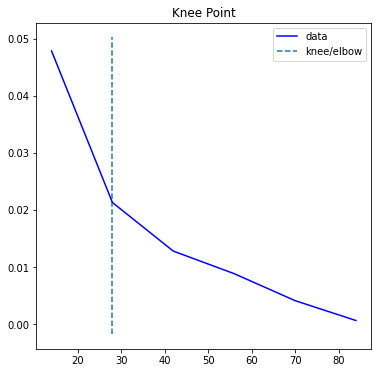

<Figure size 720x360 with 0 Axes>

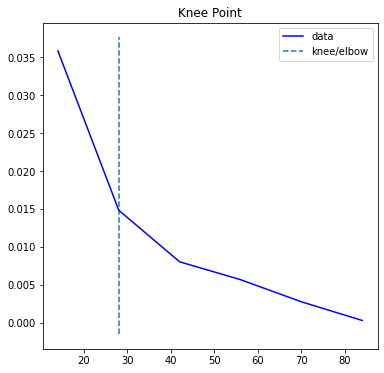

<Figure size 720x360 with 0 Axes>

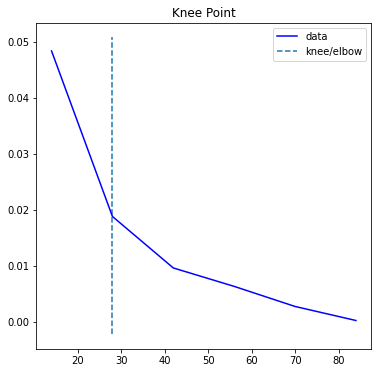

In [37]:

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3,
                    shared_yaxes=False,
                    horizontal_spacing=0.1)


df_final =  pickle.load(open("Caloriefinal_final_sim_mar22.pkl", "rb" ))
r_x = 1
for var_name in ['e_bl',  'e_alld', 'e_day']:
    temp = pd.DataFrame(np.stack([x for x in df_final[var_name]], axis=0))
    temp  = temp.dropna()
    
    print(len(temp))
    
    err =[]

    for i,T in enumerate([14, 28, 42, 56, 70, 84]):

        fig.add_trace(go.Box(y=temp[i], boxpoints=None, boxmean=True, name = str(T), line=dict(color ='olive')), row=1, col=r_x)

        err.append(np.mean(temp[i]))
    r_x+=1
    plt.figure()
    kl = KneeLocator([14, 28, 42, 56, 70, 84], err, curve="convex", direction="decreasing")
    kl.plot_knee()
    
    


fig.update_xaxes(title='$\hat{N}$', linecolor="black",  # Sets color of X-axis line
                showgrid=False )
fig.update_yaxes(range=[0,1.1],linecolor="black",  # Sets color of X-axis line
                showgrid=False)

fig.update_layout( plot_bgcolor="#FFF", 
            font=dict(
                family="Helvetica, monospace",
                size=18,
                color="black"
            )
        )

fig.update_layout(yaxis1=dict(title="$JSD_{c_l, \hat{N}}$"), yaxis2 =dict(title="$JSD_{c_d, \hat{N}}$"), yaxis3=dict(title="$JSD_{c_y, \hat{N}}$"))


fig.show()
fig.write_image("comp_paper_images/err_analysis_mar22"+".svg", engine="kaleido")





In [28]:
from math import log2
from math import sqrt
from numpy import asarray
def kl_divergence(p, q):
    
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
     
def js_divergence(p, q):
    
    p = np.array(p)
    q=np.array(q)
    if ~np.isnan(np.mean(p)) and ~np.isnan(np.mean(q)):
        p[p == 0] = 0.00001
        q[q == 0] = 0.00001
        p[np.argmax(p)] = 1-(np.sum(p) - 1)
        q[np.argmax(p)] = 1-(np.sum(q) - 1)

        m = 0.5 * (p + q)
        return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    
    else:
        
        return np.nan



df_final_table =  pd.DataFrame(columns=[])

for i in range(0, len(mfp_df)):

#             print(i)

    cal_pcts_dates = mfp_df[i]['Date'].values


    cal_pcts_dates = np.array(cal_pcts_dates)
    dates = [datetime.strptime(c, "%Y-%m-%d") for c in  cal_pcts_dates]

    record_days=len(dates)

    if record_days > 1:
        lapsing_dur = np.mean(np.diff(dates)).days-1

#         n_conse_1 = len(np.where(np.array([x.days for x in np.diff(dates)]) == 1)[0])

    if record_days >=84 and lapsing_dur<=3 and 'breakfast-cal' in mfp_df[i].keys() and 'lunch-cal' in mfp_df[i].keys() and 'dinner-cal' in mfp_df[i].keys() and 'snacks-cal' in mfp_df[i].keys() and len(mfp_df[i].keys())==22:

        print(mfp_pcts[i])

        complete_dates = cal_pcts_dates.copy()
        meal_cal = mfp_df[i].copy()

        b_cal = np.array([np.sum(vv) for vv in meal_cal['breakfast-cal'].values])
        l_cal = np.array([np.sum(vv) for vv in meal_cal['lunch-cal'].values])
        d_cal = np.array([np.sum(vv) for vv in meal_cal['dinner-cal'].values])
        s_cal = np.array([np.sum(vv) for vv in meal_cal['snacks-cal'].values])


        b_carb = np.array([np.sum(vv) for vv in meal_cal['breakfast-carb'].values])
        l_carb = np.array([np.sum(vv) for vv in meal_cal['lunch-carb'].values])
        d_carb = np.array([np.sum(vv) for vv in meal_cal['dinner-carb'].values])
        s_carb = np.array([np.sum(vv) for vv in meal_cal['snacks-carb'].values])


        b_pro = np.array([np.sum(vv) for vv in meal_cal['breakfast-protein'].values])
        l_pro = np.array([np.sum(vv) for vv in meal_cal['lunch-protein'].values])
        d_pro = np.array([np.sum(vv) for vv in meal_cal['dinner-protein'].values])
        s_pro = np.array([np.sum(vv) for vv in meal_cal['snacks-protein'].values])


        b_fat = np.array([np.sum(vv) for vv in meal_cal['breakfast-fat'].values])
        l_fat = np.array([np.sum(vv) for vv in meal_cal['lunch-fat'].values])
        d_fat = np.array([np.sum(vv) for vv in meal_cal['dinner-fat'].values])
        s_fat = np.array([np.sum(vv) for vv in meal_cal['snacks-fat'].values])



        t_cal = meal_cal["Total-cal"].values
        t_carb = meal_cal["Total-carb"].values
        t_pro = meal_cal["Total-protein"].values
        t_fat = meal_cal["Total-fat"].values


        g_cal = meal_cal["Goal"].values
        
#         if (np.mean(t_cal)<= 750):
#             print(mfp_pcts[i])
#             print(meal_cal)
#             break



        a_cal = (g_cal-t_cal)/g_cal
        aa_cal = (g_cal-t_cal)

        above_goal = len(np.where(a_cal < -0.10)[0])/len(a_cal)
        below_goal = len(np.where(a_cal >= 0)[0])/len(a_cal)


        adh_lab = below_goal

        df = meal_cal
        df['Date'] = pd.to_datetime(df['Date'])
        df["Day"] = df['Date'].dt.day_name()

        m_cal = l_cal + s_cal

        all_cal = l_cal + s_cal + b_cal

#         print('Breakfast-Lunch')


        rt_bl, _, _, _, _, _ = crosscomp(dates, b_cal, m_cal, t_cal, 'meal')



#         print('All-Dinner')
        rt_alld, _, _, _, _, _ = crosscomp(dates, all_cal, d_cal, t_cal, 'meal')


        rt_day, _, _, _, _, _ = crossday(dates, t_cal,t_cal, t_cal, 'day')
        
        e_bl = []
        e_alld = []
        e_day = []
        
        
        for T in [14, 28, 42, 56, 70, 84]:
            
            err_bl = []
            err_alld = []
            err_day = []
            
            for k_idx in range(0, len(cal_pcts_dates)-T, T):
                
                complete_dates = cal_pcts_dates[k_idx: k_idx+ T]
                
                idx_match = np.arange(k_idx, k_idx+T)
                meal_cal = mfp_df[i].iloc[idx_match].reset_index(drop=True)

                b_cal = np.array([np.sum(vv) for vv in meal_cal['breakfast-cal'].values])
                l_cal = np.array([np.sum(vv) for vv in meal_cal['lunch-cal'].values])
                d_cal = np.array([np.sum(vv) for vv in meal_cal['dinner-cal'].values])
                s_cal = np.array([np.sum(vv) for vv in meal_cal['snacks-cal'].values])


                b_carb = np.array([np.sum(vv) for vv in meal_cal['breakfast-carb'].values])
                l_carb = np.array([np.sum(vv) for vv in meal_cal['lunch-carb'].values])
                d_carb = np.array([np.sum(vv) for vv in meal_cal['dinner-carb'].values])
                s_carb = np.array([np.sum(vv) for vv in meal_cal['snacks-carb'].values])


                b_pro = np.array([np.sum(vv) for vv in meal_cal['breakfast-protein'].values])
                l_pro = np.array([np.sum(vv) for vv in meal_cal['lunch-protein'].values])
                d_pro = np.array([np.sum(vv) for vv in meal_cal['dinner-protein'].values])
                s_pro = np.array([np.sum(vv) for vv in meal_cal['snacks-protein'].values])


                b_fat = np.array([np.sum(vv) for vv in meal_cal['breakfast-fat'].values])
                l_fat = np.array([np.sum(vv) for vv in meal_cal['lunch-fat'].values])
                d_fat = np.array([np.sum(vv) for vv in meal_cal['dinner-fat'].values])
                s_fat = np.array([np.sum(vv) for vv in meal_cal['snacks-fat'].values])



                t_cal = meal_cal["Total-cal"].values
                t_carb = meal_cal["Total-carb"].values
                t_pro = meal_cal["Total-protein"].values
                t_fat = meal_cal["Total-fat"].values


                g_cal = meal_cal["Goal"].values

        #         if (np.mean(t_cal)<= 750):
        #             print(mfp_pcts[i])
        #             print(meal_cal)
        #             break



                a_cal = (g_cal-t_cal)/g_cal
                aa_cal = (g_cal-t_cal)

                above_goal = len(np.where(a_cal < -0.10)[0])/len(a_cal)
                below_goal = len(np.where(a_cal >= 0)[0])/len(a_cal)


                adh_lab = below_goal

                df = meal_cal
                df['Date'] = pd.to_datetime(df['Date'])
                df["Day"] = df['Date'].dt.day_name()

                m_cal = l_cal + s_cal

                all_cal = l_cal + s_cal + b_cal

        #         print('Breakfast-Lunch')
                datesT = [datetime.strptime(c, "%Y-%m-%d") for c in  cal_pcts_dates[idx_match]]

                rt_bl_T, _, _, _, _, _ = crosscomp(datesT, b_cal, m_cal, t_cal, 'meal')



        #         print('All-Dinner')
                rt_alld_T, _, _, _, _, _ = crosscomp(datesT, all_cal, d_cal, t_cal, 'meal')


                rt_day_T, _, _, _, _, _ = crossday(datesT, t_cal,t_cal, t_cal, 'day')
                
                err_bl.append(js_divergence(rt_bl, rt_bl_T))
                err_alld.append(js_divergence(rt_alld, rt_alld_T))
                err_day.append(js_divergence(rt_day, rt_day_T))
                
            
            e_bl.append(np.nanmedian(err_bl))
            e_alld.append(np.nanmedian(err_alld))
            e_day.append(np.nanmedian(err_day))
                
        
                





        #######################
        if len(user_prof[user_prof['uid']==mfp_pcts[i]]) !=0 :

            if pd.isna(user_prof[user_prof['uid']==mfp_pcts[i]]['gender'].values[0]): 

                gender = np.nan
            else:                      
                gender =  user_prof[user_prof['uid']==mfp_pcts[i]]['gender'].values[0]

            if pd.isna(user_prof[user_prof['uid']==mfp_pcts[i]]['age_group'].values[0]): 

                age = np.nan
            else:                      
                age =  user_prof[user_prof['uid']==mfp_pcts[i]]['age_group'].values[0]

            if pd.isna(user_prof[user_prof['uid']==mfp_pcts[i]]['regions_us'].values[0]): 

                loc = np.nan
            else:                      
                loc =  user_prof[user_prof['uid']==mfp_pcts[i]]['regions_us'].values[0]

        else:
            gender = np.nan
            age = np.nan
            loc = np.nan




        dic_all = {'uid':mfp_pcts[i], 
                                    'gender': gender,
                                    'age':age,
                                    'loc':loc, 
                                    'rt_day': rt_day,
                                    'rt_alld': rt_alld,
                                    'rt_bl': rt_bl,
                                    'e_bl': e_bl,
                                    'e_alld': e_alld,
                                    'e_day': e_day}


        df_series = pd.Series(dic_all)

        df_final_table = df_final_table.append(df_series, ignore_index=True)

        


pickle.dump(df_final_table, open("Caloriefinal_final_sim22.pkl", "wb") )
        
        
        
        
        

12
36
43
50
68
82
85
95
159
205
212
241
264
303
312
318
333
350
357
369
390
408
429
501
502
512
518
528
543
550
574
633
642
649
652
756
870
881
891
959
961
973
974
978
988
992
996
1037
1068
1085
1103
1134
1167
1203
1242
1254
1267
1279
1323
1380
1394
1427
1447
1476
1503
1595
1688
1705
1725
1728
1758
1793
1846
1851
1859
1872
1874
1877
1896
1897
1913
1920
1932
1976
1980
2059
2110
2125
2128
2133
2159
2169
2172
2182
2228
2232
2283
2294
2329
2359
2363
2380
2470
2475
2530
2542
2547
2569
2592
2610
2614
2638
2642
2647
2648
2658
2669
2681
2683
2707
2709
2718
2753
2754
2781
2784
2920
2930
2976
3008
3044
3082
3120
3149
3213
3216
3224
3229
3232
3237
3250
3277
3320
3425
3451
3476
3478
3497
3571
3574
3596
3600
3633
3641
3700
3701
3711
3729
3751
3765
3784
3807
3833
3849
3859
3872
3893
3934
3938
3961
3967
4020
4101
4106
4109
4145
4156
4158
4169
4178
4192
4226
4256
4269
4283
4309
4337
4342
4386
4447
4470
4475
4581
4645
4663
4708
4754
4787
4813
4829
4880
4885
4907
4914
4920
4955
4980
4995
5083
5096
5111


In [35]:

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3,
                    shared_yaxes=False,
                    horizontal_spacing=0.1)


df_final =  pickle.load(open("Caloriefinal_final_sim22.pkl", "rb" ))
r_x = 1
for var_name in ['e_bl',  'e_alld', 'e_day']:
    temp = pd.DataFrame(np.stack([x for x in df_final[var_name]], axis=0))
    temp  = temp.dropna()
    
    print(len(temp))

    for i,T in enumerate([14, 28, 42, 56, 70, 84]):

        fig.add_trace(go.Box(y=temp[i], boxpoints=None, boxmean=True, name = str(T), line=dict(color ='olive')), row=1, col=r_x)


    r_x+=1


fig.update_xaxes(title='$\hat{N}$', linecolor="black",  # Sets color of X-axis line
                showgrid=False )
fig.update_yaxes(range=[0,0.5],linecolor="black",  # Sets color of X-axis line
                showgrid=False)

fig.update_layout(yaxis1=dict(title="$JSD_{c_l, \hat{N}}$"), yaxis2 =dict(title="$JSD_{c_d, \hat{N}}$"), yaxis3=dict(title="$JSD_{c_y, \hat{N}}$"))



fig.update_layout( plot_bgcolor="#FFF", 
            font=dict(
                family="Helvetica, monospace",
                size=18,
                color="black"
            )
        )



fig.show()
fig.write_image("comp_paper_images/err_analysis_mar22"+".svg", engine="kaleido")





424
426
426


In [32]:

for var_name in ['tc_pos_bl',  'tc_pos_alld', 'tc_pos_day',  'tc_neg_bl', 'tc_neg_alld', 'tc_neg_day',]:    
    df_final =  pickle.load(open("Caloriefinal_2022.pkl", "rb" ))
    tcal_pos = pd.DataFrame(np.stack([x for x in df_final[var_name]], axis=0))
    tcal_pos = tcal_pos.dropna()
    
    print(len(tcal_pos))

    fig = go.Figure(layout = go.Layout(
            plot_bgcolor="#FFF",  # Sets background color to white
            xaxis=dict(
                linecolor="black",  # Sets color of X-axis line
                showgrid=False  # Removes X-axis grid lines
            ),
            yaxis=dict(
                title="",  
                linecolor="black",  # Sets color of Y-axis line
                showgrid=False,  # Removes Y-axis grid lines    
            ),
            font=dict(
                family="Helvetica",
                size=24,
                color="black"
            )
        ))

    fig.add_trace(go.Box(y=tcal_pos[2], boxpoints=None, boxmean=True, name='Over', line=dict(color ='purple')))
#     fig.add_trace(go.Box(y=tcal_pos[1], boxpoints=None, boxmean=True, name='Exact', line=dict(color ='green')))
    fig.add_trace(go.Box(y=tcal_pos[0], boxpoints=None, boxmean=True, name='Under', line=dict(color ='purple')))
    fig.add_trace(go.Box(y=tcal_pos[3], boxpoints=None, boxmean=True, name='Anti', line=dict(color ='purple')))
#     fig.add_trace(go.Box(y=tcal_pos[4], boxpoints=None, boxmean=True, name='Median', line=dict(color ='green')))
#     fig.show()

#     fig.write_image("comp_paper_images/tc_"+ var_name + ".svg", engine="kaleido")


    print(scipy.stats.friedmanchisquare(tcal_pos[2], tcal_pos[0], tcal_pos[3]))
    print(scikit_posthocs.posthoc_wilcoxon([tcal_pos[2], tcal_pos[0], tcal_pos[3]], p_adjust='bonferroni'))

#     print('median {0}, Q1 {1}, Q2 {2}'.format(np.median(tcal_pos[2]), np.percentile(tcal_pos[2], 25), np.percentile(tcal_pos[2], 75)))
#     print('median {0}, Q1 {1}, Q2 {2}'.format(np.median(tcal_pos[0]), np.percentile(tcal_pos[0], 25), np.percentile(tcal_pos[0], 75)))
#     print('median {0}, Q1 {1}, Q2 {2}'.format(np.median(tcal_pos[3]), np.percentile(tcal_pos[3], 25), np.percentile(tcal_pos[3], 75)))

    print('% {0}'.format(len(np.where(tcal_pos[2] >=0)[0])/len(tcal_pos)))
    print('% {0}'.format(len(np.where(tcal_pos[0] >= 0)[0])/len(tcal_pos)))
    print('% {0}'.format(len(np.where(tcal_pos[3]  >=0 )[0])/len(tcal_pos)))
    print('% {0}'.format(len(np.where(tcal_pos[1]  >=0 )[0])/len(tcal_pos)))







1149
FriedmanchisquareResult(statistic=550.9878048780491, pvalue=2.2621342368694727e-120)
               1             2              3
1   1.000000e+00  1.495755e-42  2.743054e-116
2   1.495755e-42  1.000000e+00   6.558816e-28
3  2.743054e-116  6.558816e-28   1.000000e+00
% 0.876414273281114
% 0.7328111401218451
% 0.6718885987815492
% 0.7771975630983464
1444
FriedmanchisquareResult(statistic=1320.6747488742637, pvalue=1.6562354936435367e-287)
               1              2              3
1   1.000000e+00  4.174217e-146  1.116864e-199
2  4.174217e-146   1.000000e+00   1.208591e-48
3  1.116864e-199   1.208591e-48   1.000000e+00
% 0.8919667590027701
% 0.6447368421052632
% 0.5914127423822715
% 0.7922437673130194
1036
FriedmanchisquareResult(statistic=1043.4845410628022, pvalue=2.571644501824892e-227)
               1              2              3
1   1.000000e+00   3.533300e-48  6.424569e-148
2   3.533300e-48   1.000000e+00  1.089648e-117
3  6.424569e-148  1.089648e-117   1.000000e+00
% 

In [36]:

cp = {1:'lightblue',2:'pink', -1:'olive', -2: 'gray'}
for pc in range(0, len(mfp_df)):

#             print(i)

    if mfp_pcts[pc]!=3404:
        
        continue
        
        
    cal_pcts_dates = mfp_df[pc]['Date'].values


    cal_pcts_dates = np.array(cal_pcts_dates)
    dates = [datetime.strptime(c, "%Y-%m-%d") for c in  cal_pcts_dates]

    record_days=len(dates)

    if record_days > 1:
        lapsing_dur = np.mean(np.diff(dates)).days-1

#         n_conse_1 = len(np.where(np.array([x.days for x in np.diff(dates)]) == 1)[0])

    if record_days >=28 and lapsing_dur<=3 and 'breakfast-cal' in mfp_df[pc].keys() and 'lunch-cal' in mfp_df[pc].keys() and 'dinner-cal' in mfp_df[pc].keys() and 'snacks-cal' in mfp_df[i].keys() and len(mfp_df[pc].keys())==22:

        print(mfp_pcts[pc])

        complete_dates = cal_pcts_dates
        meal_cal = mfp_df[pc].copy()

        b_cal = np.array([np.sum(vv) for vv in meal_cal['breakfast-cal'].values])
        l_cal = np.array([np.sum(vv) for vv in meal_cal['lunch-cal'].values])
        d_cal = np.array([np.sum(vv) for vv in meal_cal['dinner-cal'].values])
        s_cal = np.array([np.sum(vv) for vv in meal_cal['snacks-cal'].values])


        b_carb = np.array([np.sum(vv) for vv in meal_cal['breakfast-carb'].values])
        l_carb = np.array([np.sum(vv) for vv in meal_cal['lunch-carb'].values])
        d_carb = np.array([np.sum(vv) for vv in meal_cal['dinner-carb'].values])
        s_carb = np.array([np.sum(vv) for vv in meal_cal['snacks-carb'].values])


        b_pro = np.array([np.sum(vv) for vv in meal_cal['breakfast-protein'].values])
        l_pro = np.array([np.sum(vv) for vv in meal_cal['lunch-protein'].values])
        d_pro = np.array([np.sum(vv) for vv in meal_cal['dinner-protein'].values])
        s_pro = np.array([np.sum(vv) for vv in meal_cal['snacks-protein'].values])


        b_fat = np.array([np.sum(vv) for vv in meal_cal['breakfast-fat'].values])
        l_fat = np.array([np.sum(vv) for vv in meal_cal['lunch-fat'].values])
        d_fat = np.array([np.sum(vv) for vv in meal_cal['dinner-fat'].values])
        s_fat = np.array([np.sum(vv) for vv in meal_cal['snacks-fat'].values])



        t_cal = meal_cal["Total-cal"].values
        t_carb = meal_cal["Total-carb"].values
        t_pro = meal_cal["Total-protein"].values
        t_fat = meal_cal["Total-fat"].values


        g_cal = meal_cal["Goal"].values
        
#         if (np.mean(t_cal)<= 750):
#             print(mfp_pcts[i])
#             print(meal_cal)
#             break



        a_cal = (g_cal-t_cal)/g_cal
        aa_cal = (g_cal-t_cal)

        above_goal = len(np.where(a_cal < -0.10)[0])/len(a_cal)
        below_goal = len(np.where(a_cal >= 0)[0])/len(a_cal)


        adh_lab = below_goal

        df = meal_cal
        df['Date'] = pd.to_datetime(df['Date'])
        df["Day"] = df['Date'].dt.day_name()

        m_cal = l_cal + s_cal

        all_cal = l_cal + s_cal + b_cal

#         print('Breakfast-Lunch')


        

        preload=  all_cal.copy()
        test = d_cal.copy()
        total_cal= aa_cal.copy()

        preload_c = np.empty((((dates[-1]-dates[0]).days + 1)))
        test_c = np.empty((((dates[-1]-dates[0]).days + 1)))
        total_c = np.empty((((dates[-1]-dates[0]).days + 1)))

        preload_c[:] = np.nan
        test_c[:] = np.nan
        total_c[:] = np.nan



        for i,d in enumerate(dates):


            preload_c[(d-dates[0]).days] = preload[i]
            test_c[(d-dates[0]).days] = test[i]
            total_c[(d-dates[0]).days] = total_cal[i]

        
        pre = []
        tag = []
        tcal = []
        d_ind = []

        pre_all = []

        tes = []



    
        for i in range(1, len(preload_c)):

            if ~np.isnan(preload_c[i]) and ~np.isnan(np.nanmedian(preload_c[np.max([i-7, 0]): i])):

                pre_temp = preload_c[i] - np.nanmedian(preload_c[np.max([i-7, 0]): i])
                tes_temp = test_c[i] - np.nanmedian(test_c[np.max([i-7, 0]): i])
                tcal_temp = total_c[i]

                pre_all.append(pre_temp)
                ratio_temp = tes_temp/ pre_temp
                diff_temp =  np.abs(tes_temp) -  np.abs(pre_temp)
                diff_add = np.abs(tes_temp) +  np.abs(pre_temp)

                if np.abs(pre_temp) > 0 :

                    if ratio_temp>=0:

                        tag.append(2)
                        pre.append(pre_temp)
                        tcal.append(tcal_temp)
                        d_ind.append(i)
                        tes.append(tes_temp)

                    elif ratio_temp <0 and diff_temp > 0:
                        tag.append(-2)
                        pre.append(pre_temp)
                        tcal.append(tcal_temp)
                        d_ind.append(i)
                        tes.append(tes_temp)


                    elif ratio_temp<0 and diff_temp < 0:
                        tag.append(1)
                        pre.append(pre_temp)
                        tcal.append(tcal_temp)
                        d_ind.append(i)
                        tes.append(tes_temp)

                    elif ratio_temp<0 and np.abs(diff_temp) == 0:

                        tag.append(-1)
                        pre.append(pre_temp)
                        tcal.append(tcal_temp)
                        d_ind.append(i)
                        tes.append(tes_temp)


                    else:

                        continue

                else:

                    continue


            
                
     
        pre = np.array(pre)
        tag = np.array(tag)
        tcal = np.array(tcal)
        tes = np.array(tes)
        d_ind = np.array(d_ind)
    
    
        fig, axs = plt.subplots(4,  sharex=True, figsize=(16,9))
        xtic = np.arange(len(preload_c))

        axs[0].bar(xtic, preload_c, width = 0.9,  color='orange')
        axs[1].bar(xtic, test_c, width = 0.9,  color='red')
    #     axs[0].set_ylim(0,3000)
    #         axs[0].plot(dates, np.zeros(len(dates)), 'k--')
    #         axs[0].set_title('Preload')
    
        for j in range(len(d_ind)):

            axs[2].arrow(x=d_ind[j], y=0,dx=0, dy=pre[j], width = 0.15, shape='full', head_width= 0.5, head_length= 50, color = 'orange')
    #         axs[2].plot(dates, np.zeros(len(dates)), 'k--')
            axs[2].arrow(x=d_ind[j] + 0.2,y=0,dx=0, dy=tes[j], width = 0.15, shape='full', head_width= 0.5, head_length= 50, color = 'red')
    #         axs[2].set_title('Preload and test difference')
    #         axs[2].set_ylim(-500, 500)
    #         axs[2].legend()

    #         axs[1].bar(dates, test1,width = 0.8, color ='red')
    #         axs[1].set_ylim(0 ,3000)
    #         axs[1].plot(dates, np.zeros(len(dates)), 'k--')
    #         axs[1].set_title('Test')



    #         axs[2].set_title('Test difference')

            axs[3].bar(d_ind[j], 1, width = 0.9, color = cp[tag[j]], edgecolor=cp[tag[j]])
    #         axs[3].plot(dates, np.zeros(len(dates)), 'k--')
    #         axs[3].set_title('Adjustment ratio')

    #         for ax in axs.flat[-1:]:
    #             ax.set(xlabel='date', ylabel='calorie')
    #             ax.set_xticks(x_tick)
    #             ax.set_xticklabels(dates)

#         plt.savefig("comp_paper_images/timeseries.svg", format='svg')
        plt.show()
        

    

3404
